The preprocessing pipeline will include:

	1.	Resizing images to the required shape for the model (224x224).

	2.	Normalization to scale pixel values between 0 and 1.

	3.	Gaussian Blur to smooth the images.

	4.	Data Augmentation to improve generalization by applying random transformations.

Finally, we’ll integrate this processed data into the model for training and evaluation.

In [ ]:
# Step 1: Prepare the Dataset

import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageFilter
from sklearn.model_selection import train_test_split

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")

print("Path to dataset files:", path)


# Define dataset directories
yes_path =  path+ "/yes"
no_path = path+"/no"

100%|██████████| 84.0M/84.0M [00:00<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12


In [ ]:
class DatasetLister:
    def __init__(self, yes_path, no_path):
        self.yes_path = yes_path
        self.no_path = no_path

    def list_images(self):
        return {
            1: self._list_images_in_directory(self.yes_path),  # Label 1 for "yes"
            0: self._list_images_in_directory(self.no_path),  # Label 0 for "no"
        }

    def _list_images_in_directory(self, directory):
        if not os.path.exists(directory):
            raise FileNotFoundError(f"Directory not found: {directory}")
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
        return [
            os.path.join(directory, file)
            for file in os.listdir(directory)
            if file.lower().endswith(valid_extensions)
        ]

# List the images
dataset_lister = DatasetLister(yes_path, no_path)
image_data = dataset_lister.list_images()

In [ ]:
# Create a combined DataFrame for "yes" and "no" images
yes_df = pd.DataFrame({'image_path': image_data[1], 'label': 1})
no_df = pd.DataFrame({'image_path': image_data[0], 'label': 0})
combined_df = pd.concat([yes_df, no_df], ignore_index=True)

# Shuffle the DataFrame
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Step 2: Define the Preprocessing Pipeline

import random
from tensorflow.keras.utils import to_categorical

class ImagePreprocessor:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size

    def load_image(self, image_path):
        try:
            img = Image.open(image_path).convert("RGB")  # Convert to RGB
            return img
        except Exception as e:
            print(f"Error loading image at {image_path}: {e}")
            return None

    def resize_image(self, img):
        return img.resize(self.image_size)

    # def convert_to_grayscale(self, img):
    #     return ImageOps.grayscale(img)

    def normalize_image(self, img):
        return np.array(img) / 255.0

    def apply_gaussian_blur(self, img, radius=1):
        return img.filter(ImageFilter.GaussianBlur(radius))

    def augment_image(self, img):
        # Random flipping
        if random.choice([True, False]):
            img = ImageOps.mirror(img)
        if random.choice([True, False]):
            img = ImageOps.flip(img)

        # Random rotation
        angle = random.choice([0, 90, 180, 270])
        img = img.rotate(angle)

        # Random cropping
        crop_margin = 5  # Crop 5 pixels from each side
        width, height = img.size
        img = img.crop((crop_margin, crop_margin, width - crop_margin, height - crop_margin))
        img = img.resize(self.image_size)  # Resize back to original size
        return img

    def preprocess(self, image_path):
        img = self.load_image(image_path)
        if img is None:
            return None
        img = self.resize_image(img)
        # img = self.convert_to_grayscale(img)
        img = self.apply_gaussian_blur(img)
        img = self.augment_image(img)
        return self.normalize_image(img)

In [ ]:
# Initialize preprocessor
preprocessor = ImagePreprocessor(image_size=(224, 224))

# Preprocess images and store results
image_arrays = []
labels = []

for index, row in combined_df.iterrows():
    image_path = row['image_path']
    label = row['label']
    processed_image = preprocessor.preprocess(image_path)
    if processed_image is not None:
        image_arrays.append(processed_image)
        labels.append(label)

In [ ]:
# Convert to NumPy arrays
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder (if needed for categorical labels)
label_encoder = LabelEncoder()

X = np.array(image_arrays, dtype="float32")
X = X.reshape(-1, 224, 224, 3)  # Add channel dimension for grayscale

# Convert labels to binary (0 or 1) if necessary
labels = label_encoder.fit_transform(labels)  # Convert categorical to binary labels
y = np.array(labels)

# Step 3: Split Data for Training, Validation, and Testing

# First split into training and remaining data (for validation and testing)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)

# Then split the remaining data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2100, 224, 224, 3)
Validation data shape: (450, 224, 224, 3)
Testing data shape: (450, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow as tf
# Load the pre-trained ResNet50 model, adapted for grayscale images
resnet = ResNet50(
    include_top=False,  # Exclude the final dense layers
    weights='imagenet',  # Use pre-trained ImageNet weights
    input_shape=(224, 224, 3)  # Change input shape to accept grayscale images
)

In [ ]:
# Unfreeze all the layer
for layer in resnet.layers[:]:  # Adjust the range based on your model
    layer.trainable = True

In [ ]:
# Build the final model
model = Sequential()
model.add(resnet)  # Add the ResNet50 base model
model.add(Flatten())  # Flatten the output
model.add(Dense(256, activation='relu'))  # Add a dense layer
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Add the final output layer for binary classification

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary to verify the trainable layers
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 49,225,217 (187.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Training the model with callbacks for early stopping and reducing learning rate on plateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,  #trainig data
    validation_data=(X_val, y_val),  # Validation data
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


Epoch 1/30
66/66 - 106s - 2s/step - accuracy: 0.7686 - loss: 2.3609 - val_accuracy: 0.4622 - val_loss: 3509.0142 - learning_rate: 0.0010
Epoch 2/30
66/66 - 21s - 311ms/step - accuracy: 0.7514 - loss: 1.1337 - val_accuracy: 0.5378 - val_loss: 79.1191 - learning_rate: 0.0010
Epoch 3/30
66/66 - 21s - 322ms/step - accuracy: 0.8524 - loss: 0.4424 - val_accuracy: 0.5378 - val_loss: 16.3631 - learning_rate: 0.0010
Epoch 4/30
66/66 - 21s - 321ms/step - accuracy: 0.8690 - loss: 0.3909 - val_accuracy: 0.4622 - val_loss: 0.6950 - learning_rate: 0.0010
Epoch 5/30
66/66 - 20s - 307ms/step - accuracy: 0.8776 - loss: 0.3348 - val_accuracy: 0.4622 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 6/30
66/66 - 20s - 306ms/step - accuracy: 0.9129 - loss: 0.2588 - val_accuracy: 0.5378 - val_loss: 12.7954 - learning_rate: 0.0010
Epoch 7/30
66/66 - 21s - 312ms/step - accuracy: 0.9295 - loss: 0.2558 - val_accuracy: 0.5378 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 8/30
66/66 - 21s - 313ms/step - accura

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


15/15 - 1s - 84ms/step - accuracy: 0.9444 - loss: 0.2046
Test Loss: 0.20459769666194916
Test Accuracy: 0.9444444179534912


In [ ]:
# Generate predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()  # Predicted binary classes (threshold = 0.5)

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_classes)

print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[207  15]
 [ 10 218]]


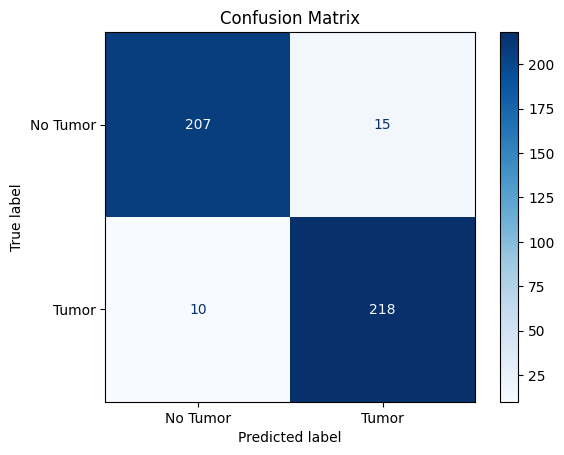

In [ ]:
# Visualize Confusion Matrix
import matplotlib.pyplot as plt
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor']).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report and Evaluation Metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['No Tumor', 'Tumor']))


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.95      0.93      0.94       222
       Tumor       0.94      0.96      0.95       228

    accuracy                           0.94       450
   macro avg       0.94      0.94      0.94       450
weighted avg       0.94      0.94      0.94       450



In [ ]:
# Calculate and Print Additional Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9444
Precision: 0.9356
Recall: 0.9561
F1 Score: 0.9458


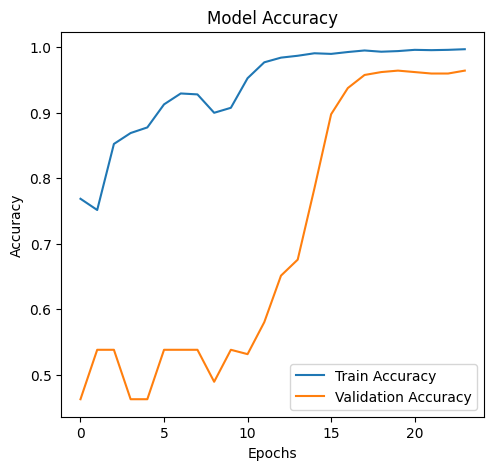

In [ ]:
# Visualize Training and Validation Curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
model.save('/content/Model/ResNet50.keras')

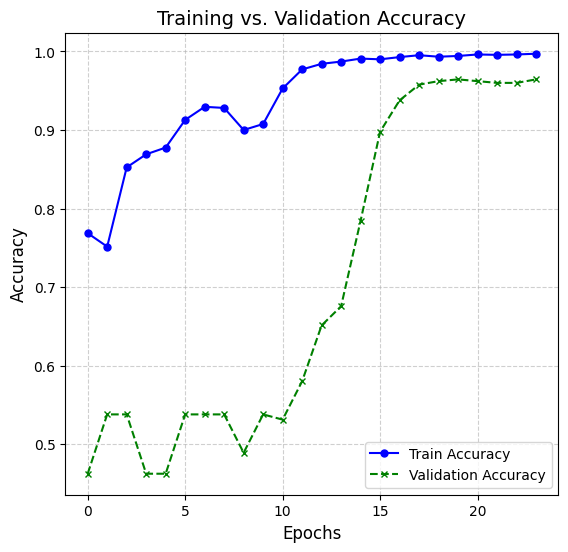

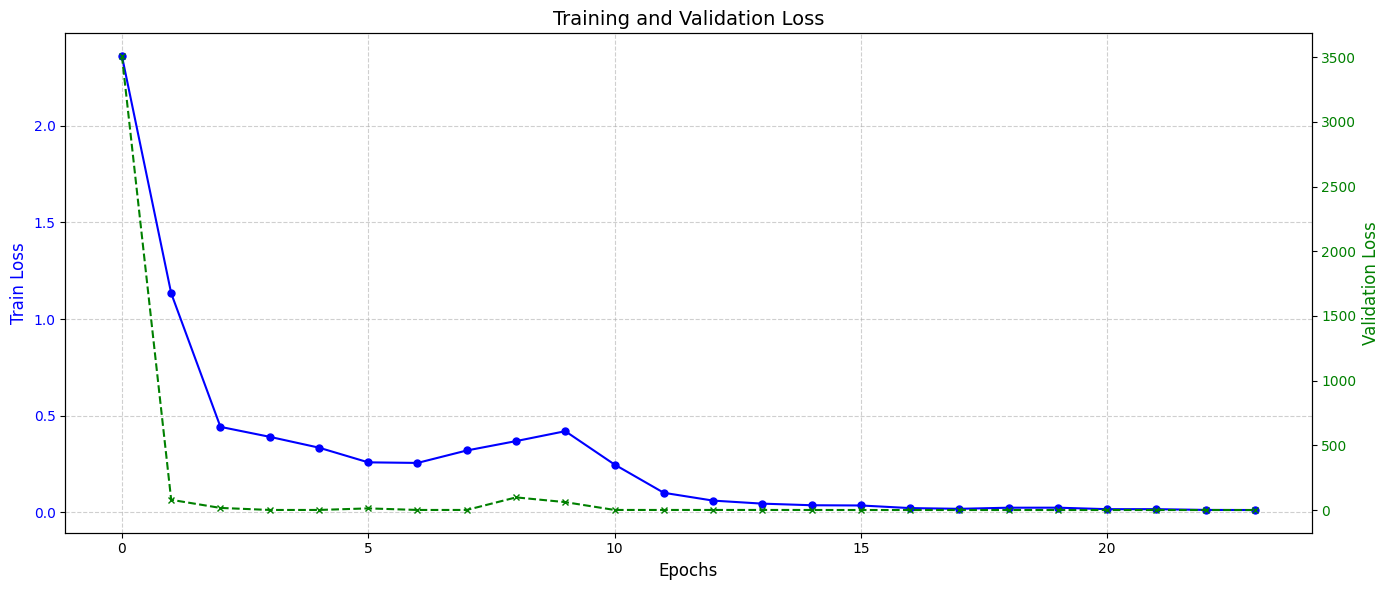

15/15 - 1s - 88ms/step - accuracy: 0.9444 - loss: 0.2046
Test Loss: 0.2046
Test Accuracy: 0.9444


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with a specific size
plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='--', marker='x', markersize=5)
plt.title('Training vs. Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Training and Validation Loss with Separate Y-Axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Training Loss on primary y-axis
ax1.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-', marker='o', markersize=5)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Train Loss', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for Validation Loss
ax2 = ax1.twinx()
ax2.plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='--', marker='x', markersize=5)
ax2.set_ylabel('Validation Loss', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title, Legends, and Grid
plt.title('Training and Validation Loss', fontsize=14)
fig.tight_layout()  # Adjust layout to avoid overlap
ax1.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

# Evaluate the model on the test set (if not done yet)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
